In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
os.chdir('/Users/jed/Documents/JED/Dataiku/drive-download-20250106T224222Z-001')
!ls

census_income_additional_info.pdf census_income_metadata.txt
census_income_learn.csv           census_income_test.csv


In [3]:
#load the train and test datasets into pandas df
train_data=pd.read_csv('census_income_learn.csv', header=None)
test_data=pd.read_csv('census_income_test.csv', header=None)


In [4]:
if len(train_data.columns) == len(test_data.columns):
    print('Both train and test datasets have same no. of columns:', len(test_data.columns))

# There are no column/feature names, will need to add these from metadata.txt file
print('n= ', len(train_data), ' for the training dataset') 
print('n= ', len(test_data), ' for the testing dataset') 

Both train and test datasets have same no. of columns: 42
n=  199523  for the training dataset
n=  99762  for the testing dataset


In [5]:
# need to add column names from metadata.txt file
column_names=['AAGE',
 'ACLSWKR',
 'ADTIND',
 'ADTOCC',
 'AGI',
 'AHGA',
 'AHRSPAY',
 'AHSCOL',
 'AMARITL',
 'AMJIND',
 'AMJOCC',
 'ARACE',
 'AREORGN',
 'ASEX',
 'AUNMEM',
 'AUNTYPE',
 'AWKSTAT',
 'CAPGAIN',
 'CAPLOSS',
 'DIVVAL',
 'FEDTAX',
 'FILESTAT',
 'GRINREG',
 'GRINST',
 'HHDFMX',
 'HHDREL',
 'MARSUPWT',
 'MIGMTR1',
 'MIGMTR2',
 'MIGMTR4',
 'MIGSAME',
 'MIGSUN',
 'NOEMP',
 'PARENT',
 'PEARNVAL',
 'PEFNTVTY',
 'PEMNTVTY',
 'PENATVTY',
 'PRCITSHP',
 'PTOTVAL',
 'SEOTR',
 'TAXINC',
 'VETQVA',
 'VETYN',
 'WKSWORK']

# AGI column is adjusted gross income, which should be removed as it is the target feature
# so should FEDTAX, PERNVAL, PTOTVAL all earning related columns 
# year of survey completion column name is missing from the txt file but is in the df
cols_to_remove=['AGI', 'FEDTAX','PEARNVAL','PTOTVAL','TAXINC', ]

for col in cols_to_remove:
    if col in column_names:
        column_names.remove(col)

column_names = column_names + ['YEAROFSUR']

# # assigned TARGET as the last column
column_names=column_names+['TARGET']

train_data.columns=column_names
test_data.columns=column_names

# # make the target variable binary as this is a binary classification task
train_data['TARGET_bin']=np.where(train_data.TARGET==' 50000+.',1,0)
test_data['TARGET_bin']=np.where(test_data.TARGET==' 50000+.',1,0)

# drop the original target variable
train_data.drop('TARGET', axis=1, inplace=True)
test_data.drop('TARGET', axis=1, inplace=True)
if len(column_names)== len(train_data.columns) == len(test_data.columns):
    print('Column names have been added to the train and test datasets')

Column names have been added to the train and test datasets


## Cleaning Data: removing duplicates, conflicting samples, outlier detection, missing data

In [6]:
# the metadata file describes a number of duplicated data points. Remove before continuing
# first step is to drop the weight column MARSUPWT as this is unique to each sample and will 
# influence the duplicate check

# check for duplicates in the training data

train_data=train_data.drop('MARSUPWT', axis=1)
dupes=train_data[train_data.duplicated(keep='first')]
print('---- Training data ----')
print('no. of duplicated samples = ',len(dupes))


# notice that the no. of duplicated samlpes without keeping the weight values is 10 times greater. By chance, the
# other features were similiar. 

# test data
test_data=test_data.drop('MARSUPWT', axis=1)
dupes=test_data[test_data.duplicated(keep='first')]
print('---- Test data ----')
print('no. of duplicated samples = ',len(dupes))


print('---- Before removing dupes ----')
print('Train: n=', len(train_data), 'Test: n=',  len(test_data))
# save the cleaned datasets
train_data=train_data.drop_duplicates()
test_data=test_data.drop_duplicates()

print('---- After removing dupes ----')
print('Train: n=', len(train_data), 'Test: n=',  len(test_data))

# train_data.to_csv('train_data_dupes_removed.csv', index=False)
# test_data.to_csv('test_data_dupes_removed.csv', index=False)

---- Training data ----
no. of duplicated samples =  46627
---- Test data ----
no. of duplicated samples =  20898
---- Before removing dupes ----
Train: n= 199523 Test: n= 99762
---- After removing dupes ----
Train: n= 152896 Test: n= 78864


In [7]:
# Metadat txt file said there are moore conflicting instances in the dataset.
# checking for samples where all features are the same but the target variable is different
print('---- Training Data ----')
df=train_data.copy()
# Identify conflicting instances
conflicting_instances = df[df.duplicated(subset=df.columns.difference(['TARGET_bin']), keep=False)]
print('no. of conflicting instances =',len(conflicting_instances))

# drop all conflicting instances, not enough information to decide which one to keep
df.drop_duplicates(subset=df.columns.difference(['TARGET_bin']), keep='first', inplace=True)
print('no. of samples after dropping conflicts = ',len(df))

train_data=df.copy()

print('---- Testing Data ----')
df=test_data.copy()
# Identify conflicting instances
conflicting_instances = df[df.duplicated(subset=df.columns.difference(['TARGET_bin']), keep=False)]
print('no. of conflicting instances =',len(conflicting_instances))

# drop all conflicting instances, not enough information to decide which one to keep
df.drop_duplicates(subset=df.columns.difference(['TARGET_bin']), keep='first', inplace=True)
print('no. of samples after dropping conflicts = ',len(df))
test_data=df.copy()

---- Training Data ----
no. of conflicting instances = 178
no. of samples after dropping conflicts =  152807
---- Testing Data ----
no. of conflicting instances = 76
no. of samples after dropping conflicts =  78826


### Outlier detection for continuous variables 
Age, Hours Worked, Weeks Worked

In [8]:
# save high earner and low earner data as sperate datasets to help with EDA
high_earner_data=train_data[train_data['TARGET_bin']==1]
low_earner_data=train_data[train_data['TARGET_bin']==0]

In [12]:
box_params=
{patch_artist=True,  # Allows custom coloring
boxprops=dict(facecolor='lightblue', color='blue', linewidth=2),
whiskerprops=dict(color='black', linewidth=2),
capprops=dict(color='black', linewidth=2),
medianprops=dict(color='red', linewidth=2),
flierprops=dict(marker='o', color='darkred', alpha=0.6),
widths=0.6}

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1050189762.py, line 1)

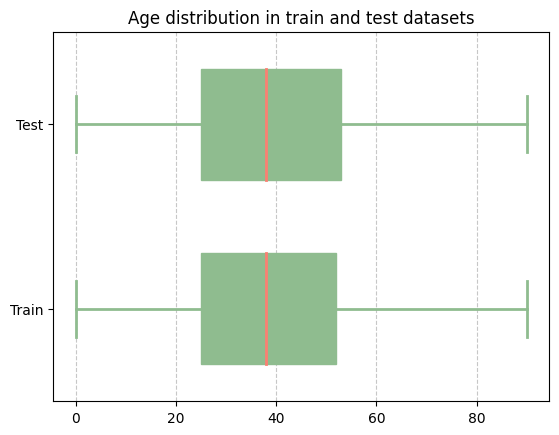

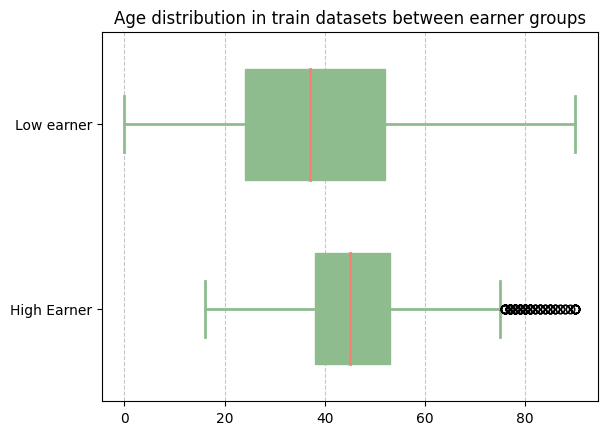

In [18]:
# check for outliers the dataset
feature='AAGE'
train_age=train_data[feature]
test_age=test_data[feature]
boxplot_settings = {
    'patch_artist': True,  # Allows custom coloring
    'boxprops': dict(facecolor='darkseagreen', color='darkseagreen', linewidth=1),
    'whiskerprops': dict(color='darkseagreen', linewidth=2),
    'capprops': dict(color='darkseagreen', linewidth=2),
    'medianprops': dict(color='salmon', linewidth=2),
    'flierprops': dict(marker='o', color='lightseagreen', alpha=0.6),
    'widths': 0.6
}


plt.boxplot([train_age, test_age], labels=['Train', 'Test'], vert=False, **boxplot_settings)
plt.title('Age distribution in train and test datasets')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# check for outliers in the high and low earner datasets
plt.boxplot([high_earner_data[feature], low_earner_data[feature]], labels=['High Earner', 'Low earner'], vert=False, **boxplot_settings)
plt.title('Age distribution in train datasets between earner groups')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# few outliers when looking at labels, I think it's ok
# leave for now, but can be removed using the code below if needed (TukeyIQR)

# label_age=np.array(train_data['AAGE'])
# q3 = np.percentile(label_age, 75)
# q1 = np.percentile(label_age, 25)
# iqr = q3 - q1

# ceiling = q3 + 1.5*iqr
# outliers = label_age[label_age > ceiling]
# print('Outliers: ', outliers)